# Performance Comparison

This notebook compares performances of Multi-label classification methods for the [academia.stackexchange.com](https://academia.stackexchange.com/).

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Prerequesits](#pre)
* [Performance Comparison](#comparison)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import re
import numpy as np
from joblib import dump, load
from pathlib import Path

ggplot_styles = {
    'axes.axisbelow': 'True',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.grid.axis': 'y',
    'figure.figsize': (12, 8),
    'font.size': 22, 
    'grid.color': 'gainsboro',
    'grid.linewidth': '0.5',
    'lines.linestyle': '-',
    'lines.linewidth': 0.7,
    'lines.marker': 'o',
    'lines.markersize': 6.0,
}

plt.rcParams.update(ggplot_styles)

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths
paths = available_classifier_paths()

<a id='pre'/>

## Prerequesits

Since the resulting classifier will act as a Recommender, the suggested labels will be evaluated by a human being. Therefore the classifier should prefer to offer more labels than less. Because of this assumption the classifiers will be evaluated and tuned for recall. Since each label itself has to have a high recall, the macro setting is used as optimization criterion.
[Notebook 3.0](3.0-me-evaluation-metrics.ipynb) contains a more detailed explanation of *recall macro*.


<a id='comparison'/>

## Performance Comparison


graphs:
- comparing transformer over all classifier
- comparing embedding transformer over vector size
- comparing classwise classifier over all transformer
- comparing classwise classifier over all transformer using undersampling / not using undersampling
- comparing classwise classifier over all transformer using gridsearch / not using gridsearch
- comparing classwise classifier over all transformer using gridsearch and undersampling / not gridsearch or undersampling
- comparing classwise classifier over all transformer using multiple classifier gridsearch


Vectorizer: `[Tfidf, Count, Word2Vec, Doc2vec, Fasttext]`

Classifier: `['ClasswiseClassifier(LinearSVC)', 'ClasswiseClassifier(LogisticRegression)', 'ClasswiseClassifier(MLPClassifier)',
'ClassifierChain(LinearSVC)', 'ClassifierChain(LogisticRegression)', 
'DecisionTreeClassifier', 'KNeighborsClassifier', 
'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))', 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))', 
'MajorityVotingClassifier(ClassifierChain(LinearSVC))', 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))', 
'MLARAM', 'MLkNN', 'MLPClassifier', 
'MultioutputClassifier(LinearSVC)', 'MultioutputClassifier(LogisticRegression)', 'RadiusNeighborsClassifier']`
            
Vector size: `[100, 200, 500, 1000, 5993]`

Preprocessing: `[Normalization, stopword removal]`

Classwise: `[Gridsearch, Undersampling]`

In [3]:
colors = {'count': 'tab:brown', 
          'tfidf': 'tab:orange', 
          'word2vec': 'tab:pink', 
          'word2vec-bigram': 'tab:purple',
          'doc2vec': 'tab:green', 
          'fasttext': 'tab:blue',
          'fasttext-bigram': 'tab:cyan'
         }

**Comparing transformer performance over all classifier**

For a first overview we can compare the different document representations for various classifiers. Details for the used transformers for document representation can be found in [notebook 2.0](2.0-me-document-representation.ipynb), while descriptions of the used classifiers can be found in [notebook 4.0](4.0-me-classification.ipynb).

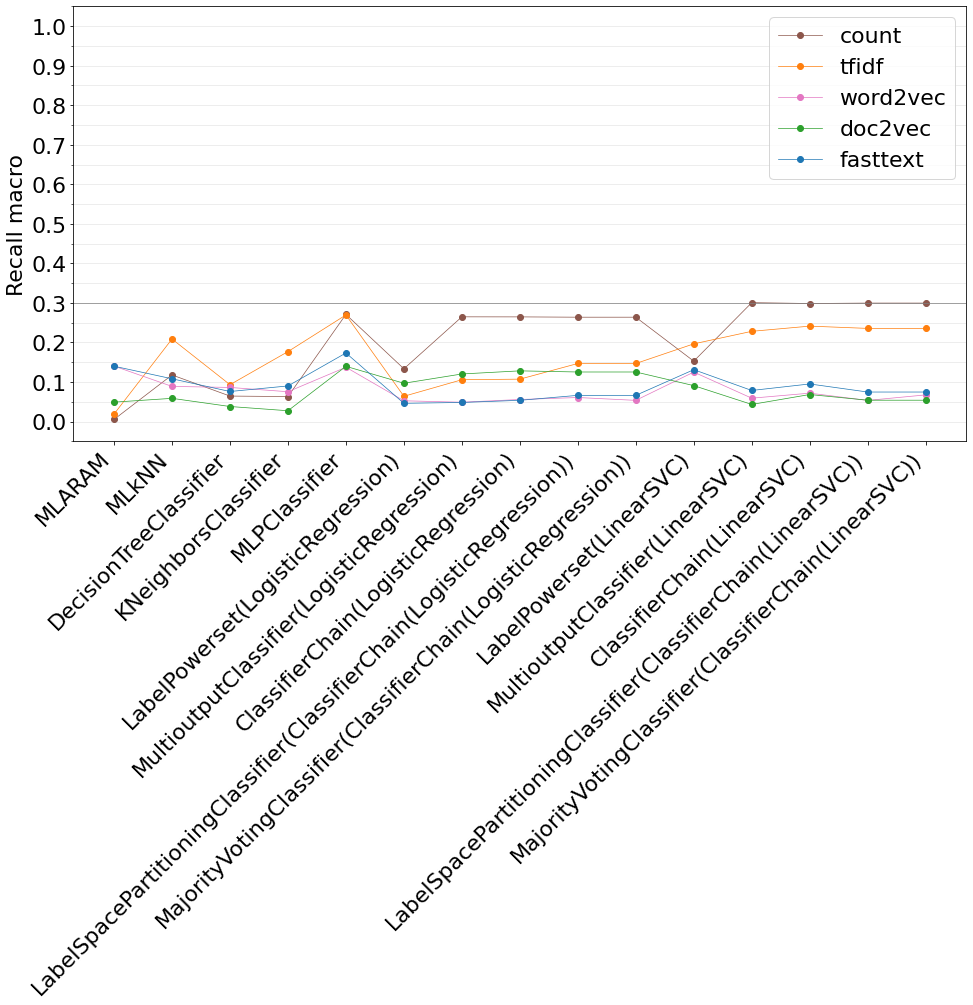

In [4]:
transformer = ['count', 'tfidf', 'word2vec', 'doc2vec', 'fasttext']
classifier = ['MLARAM', 'MLkNN',
              'DecisionTreeClassifier', 'KNeighborsClassifier', 
              'MLPClassifier',
              'LabelPowerset(LogisticRegression)', 'MultioutputClassifier(LogisticRegression)', 'ClassifierChain(LogisticRegression)', 
              'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))', 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))',
              'LabelPowerset(LinearSVC)', 'MultioutputClassifier(LinearSVC)', 'ClassifierChain(LinearSVC)', 
              'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))', 'MajorityVotingClassifier(ClassifierChain(LinearSVC))']
best_recall = (-1, '')

x_pos = np.arange(len(classifier))
fig, ax = plt.subplots(figsize=(16,8))
for transform in transformer:
    evals = []
    for path in paths:
        for i, classifier_ in enumerate(classifier):
            mask = 'name=' + classifier_ + '&v=' + transform
            if mask in path.name and ('size=100.' in path.name or not 'size' in path.name):
                clf = load(path)
                evals.append((i, clf.evaluation.recall_macro))
                if clf.evaluation.recall_macro > best_recall[0]:
                    best_recall = clf.evaluation.recall_macro, path.name
    evals.sort(key=lambda x: x[0])
    x = [eval_[0] for eval_ in evals]
    y = [eval_[1] for eval_ in evals]
    ax.plot(x, y, label=transform, color=colors[transform])
ax.set_xticks(x_pos)
ax.set_xticklabels(classifier, rotation=45, ha='right')
ax.axhline(y=best_recall[0], marker='None', color='grey')
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('Recall macro')
ax.legend(loc='best')
ax.set_title('')
plt.savefig('figures/out_of_box_classifier.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

baseline = best_recall

It can be seen, that the `Tfidf` representation outperforms the other transformer for most of the classifiers, while `Doc2vec` generally performs significantly worse. `Word2vec` and `Fasttext` are usually quite close, which makes sense since `FastText` is an improved variation of `Word2Vec`.
The same applies for `Count` and `Tfidf` representation. There implementation is very similar but `Tfidf` contains more information about the importance of different words, which explains the better performance.

The best classifiers for `Tfidf` representation are `MultioutputClassifier(LinearSVC)`, `ClassifierChain(LinearSVC)` and `MajorityVotingClassifier(ClassifierChain(LinearSVC)`. It makes sense, that they perform similar, since there implementations are similar. The `MultioutputClassifier` calculates an individual classifier for each label. The `ClassifierChain` extends that approach by using the result och each classifier for the next classifier. The `MajorityVotingClassifier(ClassifierChain)` trains a few of `ClassifierChain`s and chooses the result given by the majority of these classifiers.

We will use the best optained result as the baseline for the following analysis.

**Comparing classwise classifier over all transformer**

The results show that *Problem Transformation* approaches outperform *Algorithm Adpation* in this classification task. *Ensembles* can lead to an improvement.

To obtain better results and have more control over the classification approach, a new classification was implemented. That implementation does train a model for each label individually (like `MultioutputClassifier`. For details of that approach see [notebook 4.5.0](4.5.0-me-classwise.ipynb).
Since the previous results showed that versions of `LinearSVC`(SVM), `Logistic Regression` and `MLP`(Muli-Layer Perceptron) outperform `DecisionTree` and `kNN`, those will be used as *base classifiers*.

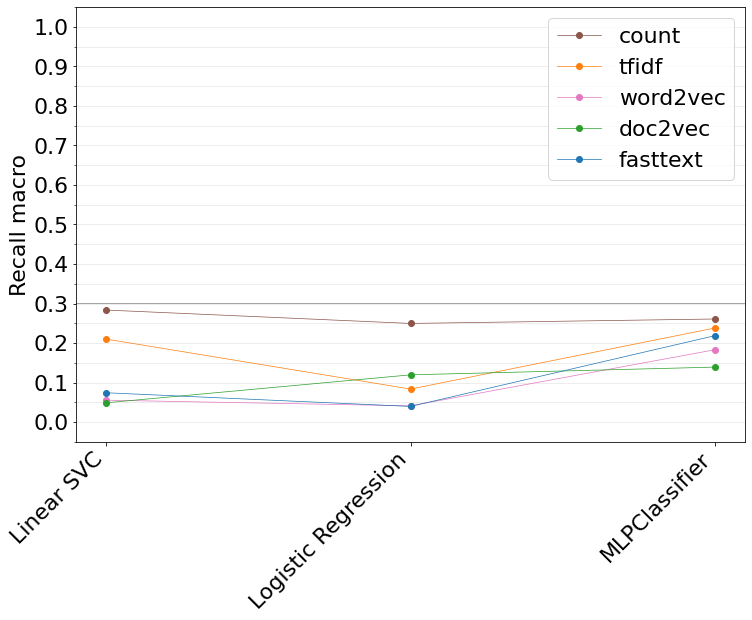

In [5]:
transformer = ['count', 'tfidf', 'word2vec', 'doc2vec', 'fasttext']
classifier = ['ClasswiseClassifier(LinearSVC)-just-classwise', 'ClasswiseClassifier(LogisticRegression)-just-classwise', 'ClasswiseClassifier(MLPClassifier)-just-classwise']
label = ['Linear SVC', 'Logistic Regression', 'MLPClassifier',]

plt.rcParams.update(ggplot_styles)

x_pos = np.arange(len(classifier))
fig, ax = plt.subplots()
for transform in transformer:
    evals = []
    for path in paths:
        for i, classifier_ in enumerate(classifier):
            mask = 'name=' + classifier_ + '&v=' + transform
            if mask in path.name:
                clf = load(path)
                evals.append((i, clf.evaluation.recall_macro))
    evals.sort(key=lambda x: x[0])
    x = [eval_[0] for eval_ in evals]
    y = [eval_[1] for eval_ in evals]
    ax.plot(x, y, label=transform, c=colors[transform])
ax.set_xticks(x_pos)
ax.set_xticklabels(label, rotation=45, ha='right')
ax.axhline(y=baseline[0], marker='None', color='grey')
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('Recall macro')
ax.legend(loc='best')
ax.set_title('')
plt.savefig('figures/classwise_classifier.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

Like expected, the results are very close to the ones using `MultioutputClassifier`. The `Tfidf` document representation outperforms the others for `LinearSVC` and `LogisticRegression`. Using the `MLPClassifier` with `FastText` representation results in the same recall. The important thing to note is, that the `Tfidf` representation uses 5993 features, while the `FastText` representation uses only 100 features, resulting in a lower training time.

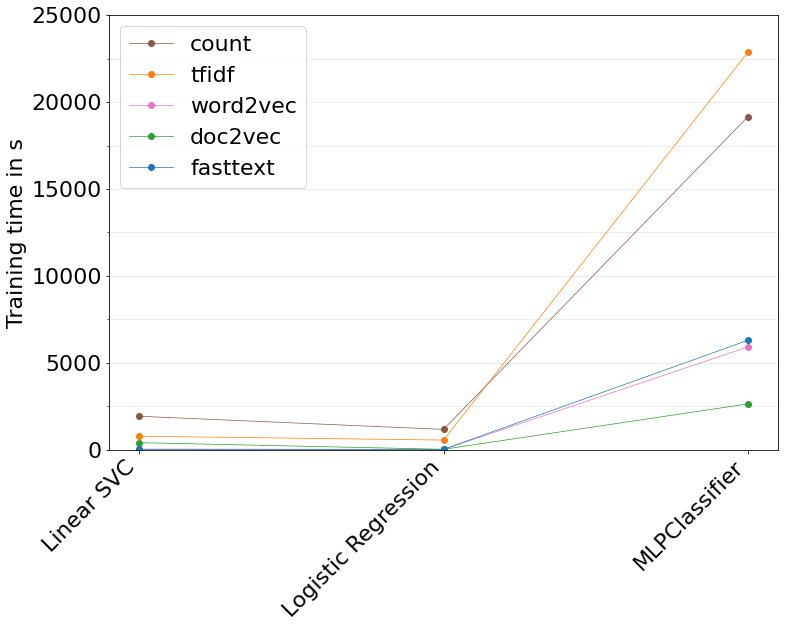

In [6]:
transformer = ['count', 'tfidf', 'word2vec', 'doc2vec', 'fasttext']
classifier = ['ClasswiseClassifier(LinearSVC)-just-classwise', 'ClasswiseClassifier(LogisticRegression)-just-classwise', 'ClasswiseClassifier(MLPClassifier)-just-classwise']
label = ['Linear SVC', 'Logistic Regression', 'MLPClassifier',]


x_pos = np.arange(len(classifier))
fig, ax = plt.subplots()
for transform in transformer:
    evals = []
    for path in paths:
        for i, classifier_ in enumerate(classifier):
            mask = 'name=' + classifier_ + '&v=' + transform
            if mask in path.name:
                clf = load(path)
                evals.append((i, clf.training_time))
    evals.sort(key=lambda x: x[0])
    x = [eval_[0] for eval_ in evals]
    y = [eval_[1] for eval_ in evals]
    ax.plot(x, y, label=transform, color=colors[transform])
ax.set_xticks(x_pos)
ax.set_xticklabels(label, rotation=45, ha='right')
ax.yaxis.set_major_locator(MultipleLocator(5000))
ax.yaxis.set_minor_locator(MultipleLocator(2500))
ax.set_ylim(-0.05, 25000.05)
ax.set_ylabel('Training time in s')
ax.legend(loc='best')
ax.set_title('')
plt.savefig('figures/classwise_classifier_time.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

The difference in training time is not that nig for simple classification methods like `LinearSVC` and `Logistic Regression`, but increases significantly for `MLPClassifier`.

**Comparing feature size for embedding transformer**

The embedded document representations use 100 features per default. To investigate on the effect of a bigger feature space the `MultioutputClassifier(LogisticRegression)` is trained for feature sizes: 100, 200, 500, 1000.

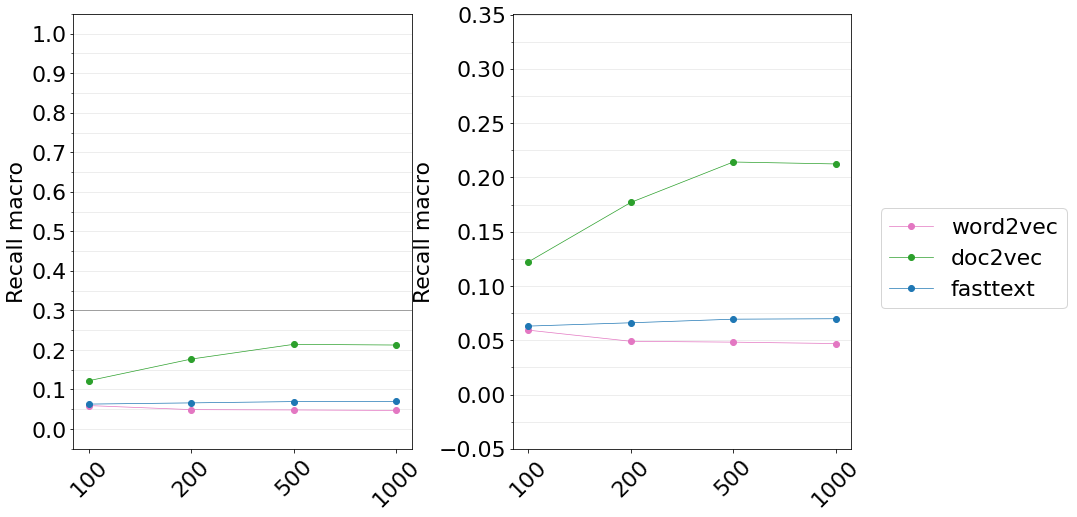

In [7]:
transformer = ['word2vec', 'doc2vec', 'fasttext']
vector_sizes = [100, 200, 500, 1000]

x = np.arange(len(vector_sizes))

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for transform in transformer:
    evals = np.zeros(len(vector_sizes))
    for path in paths:
        for i, size in enumerate(vector_sizes):
            mask = 'v=' + transform + '&size=' + str(size)
            if mask in path.name:
                clf = load(path)
                evals[i] = clf.evaluation.recall_macro
    ax[0].plot(x, evals, label=transform, color=colors[transform])
    ax[1].plot(x, evals, label=transform, color=colors[transform])
ax[0].set_xticks(x)
ax[0].set_xticklabels(vector_sizes, rotation=45)
ax[0].axhline(y=baseline[0], marker='None', color='grey')
ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].set_ylim(-0.05, 1.05)
ax[0].set_ylabel('Recall macro')

ax[1].set_xticks(x)
ax[1].set_xticklabels(vector_sizes, rotation=45)
ax[1].yaxis.set_major_locator(MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.025))
ax[1].set_ylim(-0.05, baseline[0]+0.05)
ax[1].set_ylabel('Recall macro')

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='right')
plt.subplots_adjust(wspace=0.3, right=0.8)
plt.savefig('figures/embedding_size.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

There is no significant improve in recall by increasing the feature vector size.

**Comparing embedding transformer using only unigrams or unigrams and bigrams**

The embedded transformer `Word2Vec` and `FastText` can be extended with multiword n-grams. (e.g. `non academic` as well as `non` and `academic`).

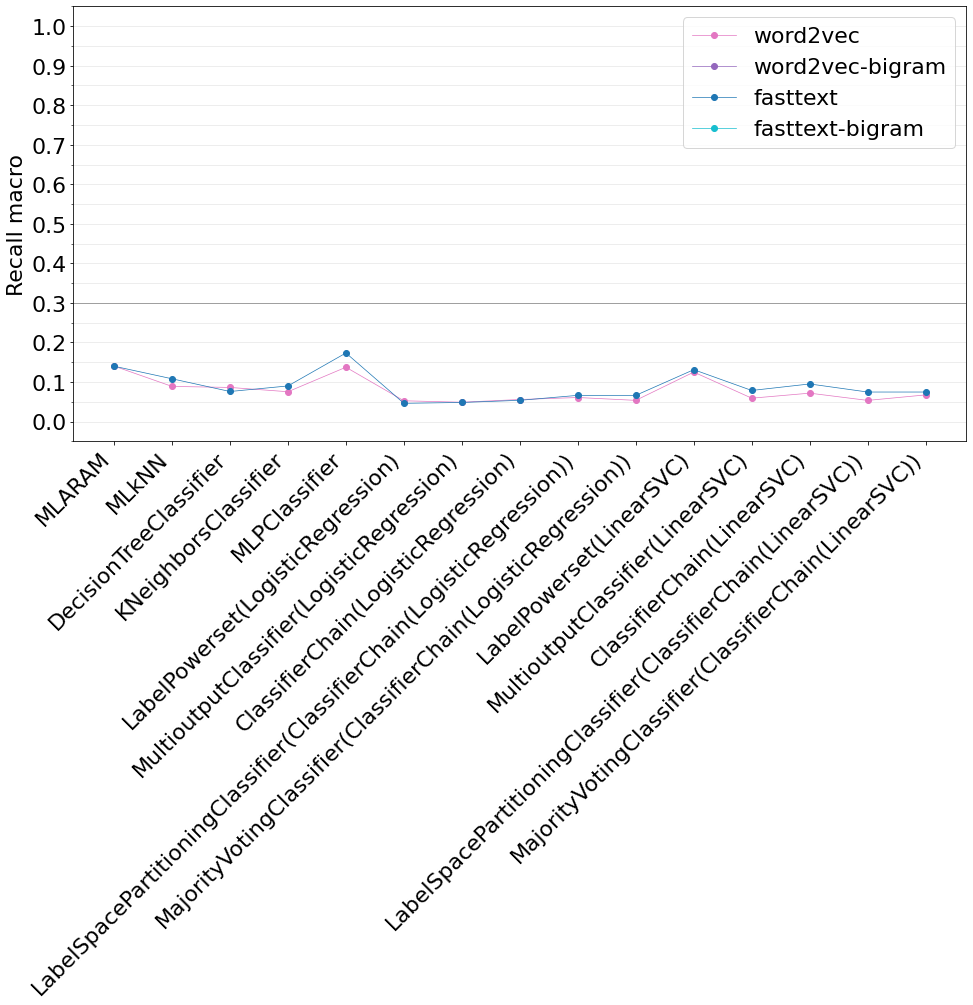

In [8]:
transformer = ['word2vec', 'word2vec-bigram', 'fasttext', 'fasttext-bigram']
classifier = ['MLARAM', 'MLkNN',
              'DecisionTreeClassifier', 'KNeighborsClassifier', 
              'MLPClassifier',
              'LabelPowerset(LogisticRegression)', 'MultioutputClassifier(LogisticRegression)', 'ClassifierChain(LogisticRegression)', 
              'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))', 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))',
              'LabelPowerset(LinearSVC)', 'MultioutputClassifier(LinearSVC)', 'ClassifierChain(LinearSVC)', 
              'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))', 'MajorityVotingClassifier(ClassifierChain(LinearSVC))']

x_pos = np.arange(len(classifier))
fig, ax = plt.subplots(figsize=(16, 8))
for transform in transformer:
    evals = []
    for path in paths:
        for i, classifier_ in enumerate(classifier):
            mask = 'name=' + classifier_ + '&v=' + transform + '&'
            if mask in path.name and ('size=100.' in path.name or not 'size' in path.name):
                clf = load(path)
                evals.append((i, clf.evaluation.recall_macro))
    evals.sort(key=lambda x: x[0])
    x = [eval_[0] for eval_ in evals]
    y = [eval_[1] for eval_ in evals]
    ax.plot(x, y, label=transform, color=colors[transform])
ax.set_xticks(x_pos)
ax.set_xticklabels(classifier, rotation=45, ha='right')
ax.axhline(y=baseline[0], marker='None', color='grey')
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('Recall macro')
ax.legend(loc='best')
ax.set_title('')
plt.savefig('figures/embedding_bigram.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

The results show that using bigrams can potencially decrease the classifiers performance. This effect is bigger for the `Word2Vec` transormer than for `FastText`.

**Comparing classwise classifier over all transformer using undersampling / not using undersampling**

The data for the individual labels is unbalanced, as can be seen in [notebook 1.0](1.0-me-initial-data-exploration.ipynb).
A common approach to deal with unbalanced data is *undersampling* (see [notebook 4.5.2](4.5.2-me-classwise-undersampling)), which can lead to a higher classification rate for the minority class. The minority class, in this case, is each label being positive.

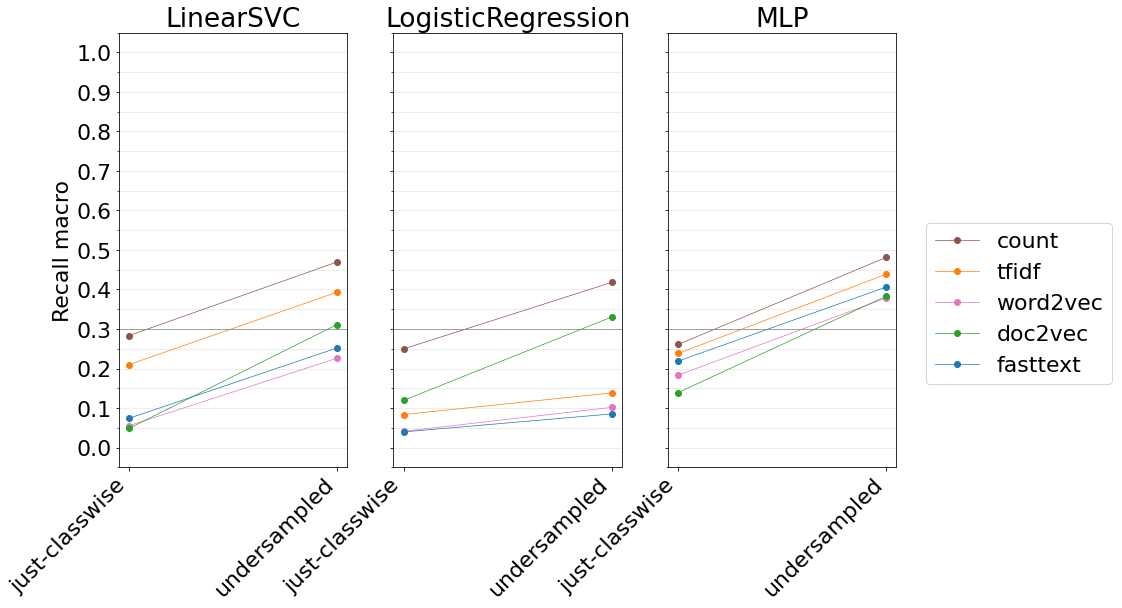

In [9]:
transformer = ['count', 'tfidf', 'word2vec', 'doc2vec', 'fasttext']
label = ['Linear SVC', 'Linear SVC - undersampled',
        'Logistic Regression', 'Logistic Regression - undersampled',
        'MLPClassifier', 'MLPClassifier - undersampled']
base_classifier = ['LinearSVC', 'LogisticRegression', 'MLP']
variations = ['just-classwise', 'undersampled']

x_pos = np.arange(len(variations))
fig, ax = plt.subplots(1, 3, figsize=(16,8), sharey=True)
for idx, clf in enumerate(base_classifier):
    ax[idx].set_title(clf)
    for transform in transformer:
        evals = []
        for path in paths:
            for i, variation in enumerate(variations):
                if clf in path.name and transform in path.name and variation in path.name:
                    recall = load(path).evaluation.recall_macro
                    evals.append((i, recall))
        evals.sort(key=lambda x: x[0])
        x = [eval_[0] for eval_ in evals]
        y = [eval_[1] for eval_ in evals]
        ax[idx].plot(x, y, label=transform, color=colors[transform])
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(variations, rotation=45, ha='right')
    ax[idx].axhline(y=baseline[0], marker='None', color='grey')
    ax[idx].yaxis.set_major_locator(MultipleLocator(0.1))
    ax[idx].yaxis.set_minor_locator(MultipleLocator(0.05))
    ax[idx].set_ylim(-0.05, 1.05)
ax[0].set_ylabel('Recall macro')
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='right')
plt.subplots_adjust(right=0.8)
plt.savefig('figures/classwise_classifier_undersampled.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

The results show that undersampling does improve over the simple classwise approach. Especially the performance of `MLPClassifier` does improve significantly for all document representations except `Doc2Vec`.

**Comparing classwise classifier over all transformer using gridsearch / not using gridsearch**

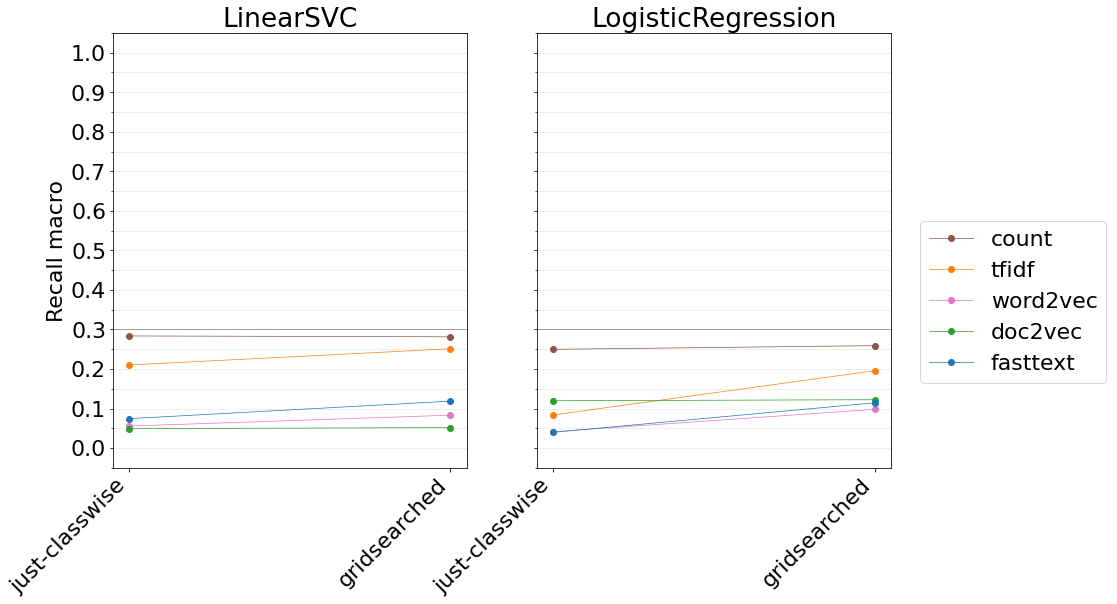

In [10]:
transformer = ['count', 'tfidf', 'word2vec', 'doc2vec', 'fasttext']
label = ['Linear SVC', 'Linear SVC - gridsearched',
        'Logistic Regression', 'Logistic Regression - gridsearched',
        'MLPClassifier', 'MLPClassifier - gridsearched']
base_classifier = ['LinearSVC', 'LogisticRegression']
variations = ['just-classwise', 'gridsearched']

x_pos = np.arange(len(variations))
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True)
for idx, clf in enumerate(base_classifier):
    ax[idx].set_title(clf)
    for transform in transformer:
        evals = []
        for path in paths:
            for i, variation in enumerate(variations):
                if clf in path.name and transform in path.name and variation in path.name:
                    recall = load(path).evaluation.recall_macro
                    evals.append((i, recall))
        evals.sort(key=lambda x: x[0])
        x = [eval_[0] for eval_ in evals]
        y = [eval_[1] for eval_ in evals]
        ax[idx].plot(x, y, label=transform, color=colors[transform])
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(variations, rotation=45, ha='right')
    ax[idx].axhline(y=baseline[0], marker='None', color='grey')
    ax[idx].yaxis.set_major_locator(MultipleLocator(0.1))
    ax[idx].yaxis.set_minor_locator(MultipleLocator(0.05))
    ax[idx].set_ylim(-0.05, 1.05)
ax[0].set_ylabel('Recall macro')
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='right')
plt.subplots_adjust(right=0.8)
plt.savefig('figures/classwise_classifier_gridsearched.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

**Comparing classwise classifier over all transformer using gridsearch / not using gridsearch and undersampling / not undersampling**

After seeing the results using *undersampling* and *gridsearch* we combine both approaches to obtain even better results. Since `MLPClassifier` does already have a high training time withouth *gridsearch*, this experiment will only be done for `LinearSVC` and `LogisticRegression`.

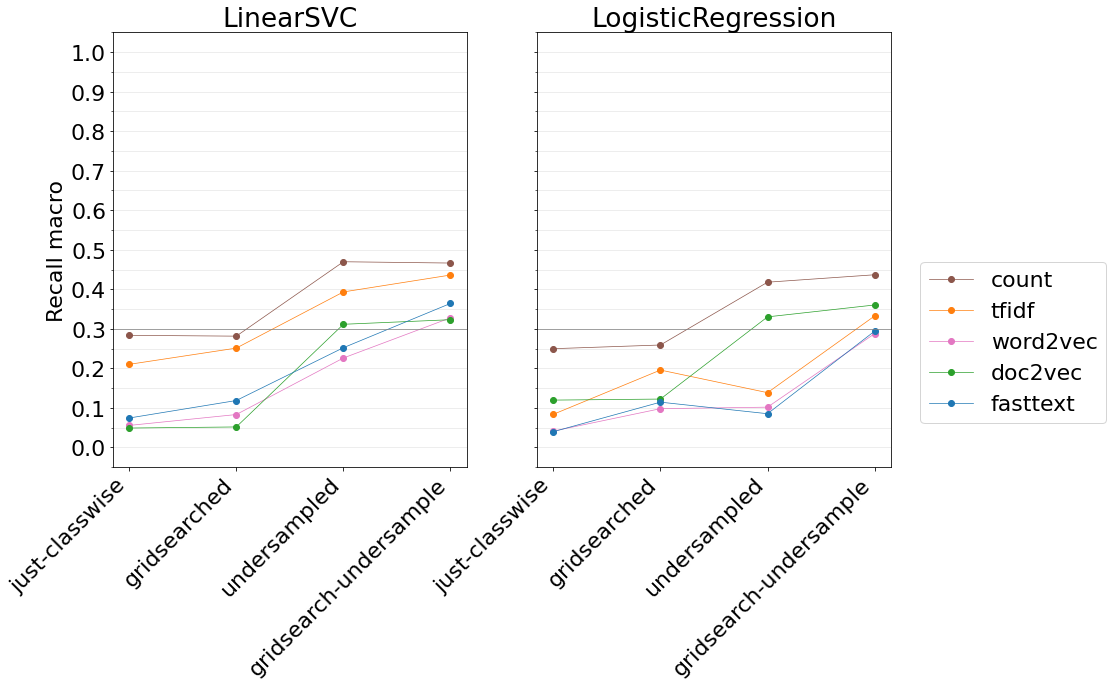

In [11]:
transformer = ['count', 'tfidf', 'word2vec', 'doc2vec', 'fasttext']
label = ['Linear SVC', 'Linear SVC - undersampled', 'Linear SVC - gridsearched', 'Linear SVC - gridsearch and undersampled',
        'Logistic Regression', 'Logistic Regression - undersampled', 'Logistic Regression - gridsearched', 'Logistic Regression - gridsearch and undersampled']
base_classifier = ['LinearSVC', 'LogisticRegression']
variations = ['just-classwise', 'gridsearched', 'undersampled', 'gridsearch-undersample']

x_pos = np.arange(len(variations))
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True)
for idx, clf in enumerate(base_classifier):
    ax[idx].set_title(clf)
    for transform in transformer:
        evals = []
        for path in paths:
            for i, variation in enumerate(variations):
                if clf in path.name and transform in path.name and variation in path.name:
                    recall = load(path).evaluation.recall_macro
                    evals.append((i, recall))
        evals.sort(key=lambda x: x[0])
        x = [eval_[0] for eval_ in evals]
        y = [eval_[1] for eval_ in evals]
        ax[idx].plot(x, y, label=transform, color=colors[transform])
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(variations, rotation=45, ha='right')
    ax[idx].axhline(y=baseline[0], marker='None', color='grey')
    ax[idx].yaxis.set_major_locator(MultipleLocator(0.1))
    ax[idx].yaxis.set_minor_locator(MultipleLocator(0.05))
    ax[idx].set_ylim(-0.05, 1.05)
ax[0].set_ylabel('Recall macro')
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='right')
plt.subplots_adjust(right=0.8)
plt.savefig('figures/classwise_classifier_gridsearched_undersampled.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()

It can be seen that combining gridsearch and undersampling does improve the results for `Word2Vec` and `FastText` representation. While it does not improve the performance significantly for the other document representations.

The results are still not as high as with using the `MLPClassifier`.

**Comparing classwise classifier over all transformer using multiple classifier gridsearch**

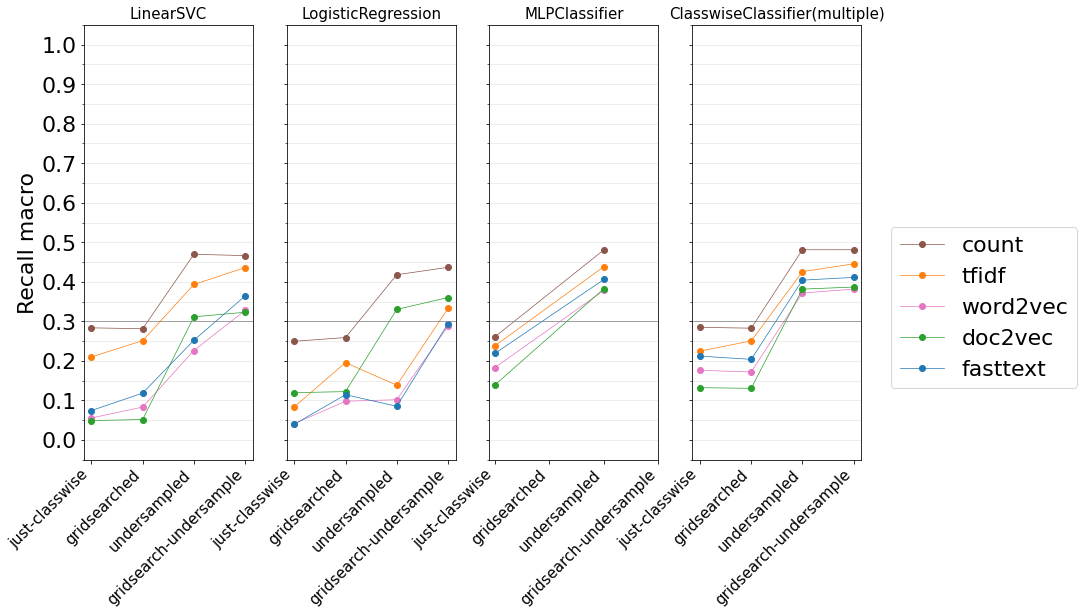

In [12]:
transformer = ['count', 'tfidf', 'word2vec', 'doc2vec', 'fasttext']
label = ['Linear SVC', 'Linear SVC - undersampled', 'Linear SVC - gridsearched', 'Linear SVC - gridsearch and undersampled',
        'Logistic Regression', 'Logistic Regression - undersampled', 'Logistic Regression - gridsearched', 'Logistic Regression - gridsearch and undersampled']
base_classifier = ['LinearSVC', 'LogisticRegression', 'MLPClassifier', 'ClasswiseClassifier(multiple)']
variations = ['just-classwise', 'gridsearched', 'undersampled', 'gridsearch-undersample']

x_pos = np.arange(len(variations))
fig, ax = plt.subplots(1, 4, figsize=(16,8), sharey=True)
for idx, clf in enumerate(base_classifier):
    ax[idx].set_title(clf, fontsize=15)
    for transform in transformer:
        evals = []
        for path in paths:
            for i, variation in enumerate(variations):
                if clf in path.name and transform in path.name and variation in path.name:
                    recall = load(path).evaluation.recall_macro
                    evals.append((i, recall))
        evals.sort(key=lambda x: x[0])
        x = [eval_[0] for eval_ in evals]
        y = [eval_[1] for eval_ in evals]
        ax[idx].plot(x, y, label=transform, color=colors[transform])
    ax[idx].set_xticks(x_pos)
    ax[idx].set_xticklabels(variations, rotation=45, ha='right', fontsize=15)
    ax[idx].axhline(y=baseline[0], marker='None', color='grey')
    ax[idx].yaxis.set_major_locator(MultipleLocator(0.1))
    ax[idx].yaxis.set_minor_locator(MultipleLocator(0.05))
    ax[idx].set_ylim(-0.05, 1.05)
ax[0].set_ylabel('Recall macro')
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='right')
plt.subplots_adjust(right=0.8)
plt.savefig('figures/classwise_classifier_gridsearched_undersampled_multiple.png', bbox_inches='tight', orientation='landscape', dpi=300)
plt.show()